In [1]:
import numpy as np

import  matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt

import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd

import scipy
from scipy import stats

import xarray as xa

In [2]:
all0205 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_200207-200505.nc", engine='netcdf4')
all0508 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_200506-200804.nc", engine='netcdf4')
all0811 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_200805-201103.nc", engine='netcdf4')
all1114 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_201104-201402.nc", engine='netcdf4')
all1417 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_201403-201701.nc", engine='netcdf4')
all1821 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_201702-201912.nc", engine='netcdf4')
all2123 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_202001-202211.nc", engine='netcdf4')
all2223 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_202212-202302.nc", engine='netcdf4')

In [3]:
var = "toa_lw"
alllw = xa.concat( [all0205[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all0508[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all0811[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all1114[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all1417[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all1821[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all2123[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],], 
               dim='time')

In [4]:
var = "toa_sw"
allsw = xa.concat( [all0205[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all0508[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all0811[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all1114[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all1417[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all1821[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all2123[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],], 
               dim='time')

In [5]:
#Gistemp Surface temp by lat, lon and time
#st_global_anom_raghu = xa.open_dataset("../daa/gistemp1200_GHCNv4_ERSSTv5.nc").sel(time=ragutime).tempanomaly
#gmst_anom_raghu = st_global_anom_raghu.mean(["lat", "lon"])
#gmst_anom_raghu 

In [6]:
#0
trop = slice(-30,30)
ragutime = slice('2002-07-15T00:00:00.000000000','2020-12-15T00:00:00.000000000' )

In [7]:
RclrLW_trop = alllw.sel(lat=trop,time=ragutime).toa_lw_clr_mon.mean("lon")
RovcLW_trop = alllw.sel(lat=trop,time=ragutime).toa_lw_cldtyp_mon.mean("lon")
lwK_trop = (RclrLW_trop - RovcLW_trop)/100

In [8]:
RclrSW_trop = allsw.sel(lat=trop,time=ragutime).toa_sw_clr_mon.mean("lon")
RovcSW_trop = allsw.sel(lat=trop,time=ragutime).toa_sw_cldtyp_mon.mean("lon")
swK_trop = (RclrSW_trop - RovcSW_trop)/100

In [9]:
#1d
K_trop = lwK_trop + swK_trop
K_trop

<xarray.DataArray (time: 222, lat: 60, opt: 6, press: 7)>
array([[[[-6.95322827e-02,  3.64839882e-02,  8.21122974e-02, ...,
           2.25793272e-01,  2.04872966e-01,  7.49827921e-02],
         [-1.62981927e-01, -6.67938590e-02,  3.76801491e-02, ...,
           3.13377500e-01,  4.12711978e-01,  3.57284546e-01],
         [-3.40756178e-01, -2.39068091e-01, -9.13528800e-02, ...,
           2.37454534e-01,  4.44557786e-01,             nan],
         [-5.62052011e-01, -4.30202931e-01, -2.85203397e-01, ...,
           5.42105436e-02,  2.92046666e-01,             nan],
         [-7.38983631e-01, -5.92498481e-01, -4.67242599e-01, ...,
          -9.60992575e-02,  1.48593426e-01,             nan],
         [-8.96904230e-01, -7.89884746e-01, -6.86066270e-01, ...,
          -2.32035637e-01,  6.15028143e-02,  3.62516999e-01]],

        [[-6.88544065e-02,  4.08401489e-02,  8.98803324e-02, ...,
           2.18167841e-01,  2.13180110e-01,  5.63667268e-02],
         [-1.70478523e-01, -6.60903454e-02,  3.68929505e-02, ...,
           3.18872720e-01,  4.23389077e-01,  1.86389953e-01],
         [-3.47768605e-01, -2.52343833e-01, -1.08421326e-01, ...,
           2.30587900e-01,  4.48855877e-01,             nan],
         [-5.74028909e-01, -4.45169687e-01, -3.01013947e-01, ...,
...
         [-5.49480498e-01, -4.36248958e-01, -3.00791979e-01, ...,
           6.08726740e-02,  2.84405172e-01,             nan],
         [-7.56479204e-01, -6.28482819e-01, -5.21334887e-01, ...,
          -1.25935137e-01,  1.22711658e-01,  3.97061825e-01],
         [-8.56575906e-01, -8.30076456e-01, -7.36992836e-01, ...,
          -3.32523346e-01,  1.20261908e-02,  3.00069809e-01]],

        [[-6.88076392e-02,  4.93827388e-02,  1.28590971e-01, ...,
           2.50883698e-01,  2.62027085e-01,  1.58594668e-01],
         [-1.67061299e-01, -4.12570089e-02,  7.99615383e-02, ...,
           3.14928621e-01,  4.09985334e-01,  3.39138985e-01],
         [-3.51219714e-01, -2.07177818e-01, -7.20238686e-02, ...,
           2.42989719e-01,  4.26641285e-01,             nan],
         [-5.50227284e-01, -4.13185418e-01, -2.83401519e-01, ...,
           6.33349419e-02,  2.95367837e-01,             nan],
         [-7.50771999e-01, -6.28568172e-01, -4.94578242e-01, ...,
          -1.21966183e-01,  1.33485675e-01,  3.80871654e-01],
         [-8.30153108e-01, -8.16523433e-01, -7.18631148e-01, ...,
          -3.01263452e-01,  6.15183115e-02,  2.83497334e-01]]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-15 2002-08-15 ... 2020-12-15
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * press    (press) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0
  * opt      (opt) float32 0.0 1.0 2.0 3.0 4.0 5.0

Text(0.5, 1.0, 'c) Tropical-mean net kernel')

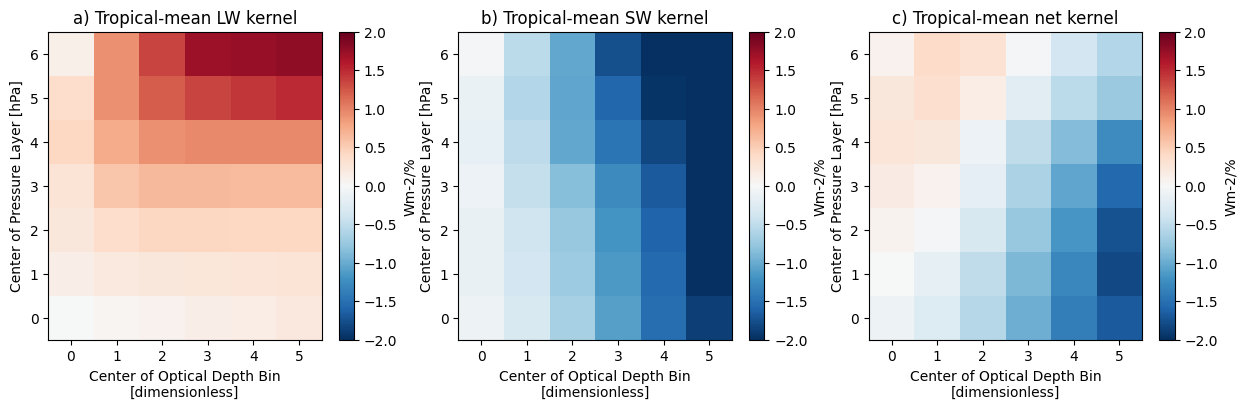

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

#fig.suptitle('Horizontally stacked subplots')
lwK_trop.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax1)
ax1.set_title("a) Tropical-mean LW kernel")
swK_trop.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax2)
ax2.set_title("b) Tropical-mean SW kernel")
K_trop.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax3)
ax3.set_title("c) Tropical-mean net kernel")
#plt.savefig("kernels.png")

In [11]:
#Another way of testing if the kernels values are ok
p = np.array([1000.0 ,  800.0,  680,  560,  440, 310.0,  180,  10])
midpoints = [(p[i] + p[i -1])/2 for i in np.arange(len(p)) ]
midpoints

[505.0, 900.0, 740.0, 620.0, 500.0, 375.0, 245.0, 95.0]

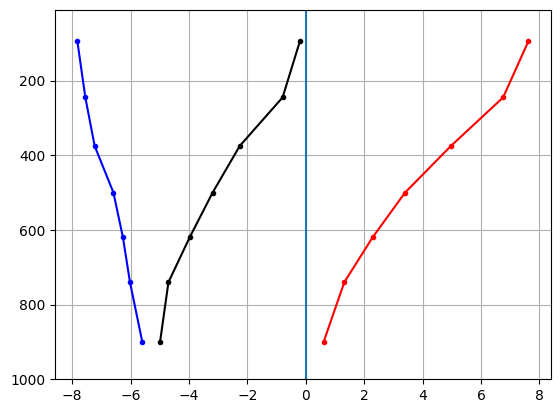

In [12]:

plt.plot(lwK_trop.mean(["lat","time"]).sum("opt"),  midpoints[1:], ".-r")
plt.plot(swK_trop.mean(["lat","time"]).sum("opt"),  midpoints[1:], ".-b")
plt.plot(K_trop.mean(["lat","time"]).sum("opt"), midpoints[1:], ".-k")
plt.gca().invert_yaxis()
plt.ylim(1000,10)
plt.vlines(0, ymin=1000, ymax=10)
plt.grid()

In [13]:
#2
area_trop = alllw.cldarea_cldtyp_mon.sel(lat=trop, time=ragutime).mean("lon")
cc_trop_anom = area_trop.groupby('time.month')- area_trop.groupby('time.month').mean('time')

In [14]:
#3
lwR_trop = lwK_trop*cc_trop_anom
swR_trop = swK_trop*cc_trop_anom

In [15]:
#4
lwR_trop_mean = lwR_trop.mean(['lat'])
swR_trop_mean = swR_trop.mean(['lat'])

In [23]:
#5
#Gistemp GMST anomalies
gmst = pd.read_csv("../daa/GLB.Ts+dSST.csv", skiprows=[0])

gmst = gmst.loc[ gmst['Year'] >= 2002 ]
gmst = gmst.loc[ gmst['Year'] < 2021 ]
lista_gmst = gmst[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']].values.flatten().tolist()
#lista_gmst, len(lista_gmst)
lista_gmst[6:]
#NOT the same as meaqning across all the values, which gives:0.7340974 , 0.23327379, 0.95729756, 0.8614268 , 0.7519227... 
gmst_anom_raghu = np.array(lista_gmst[6:], dtype=np.float16)
gmst_anom_raghu.shape

(222,)

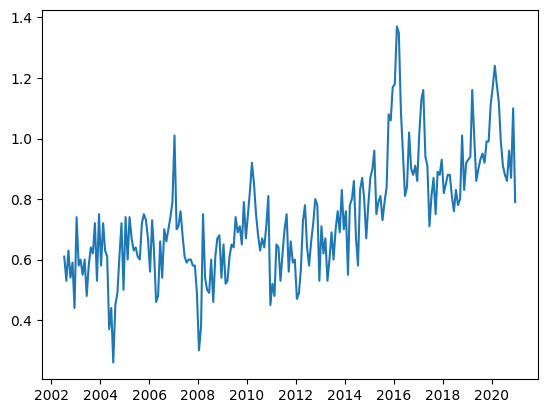

In [25]:
plt.plot(alllw.cldarea_cldtyp_mon.sel(lat=trop, time=ragutime).time, gmst_anom_raghu ) #The GMST anomalies 

In [107]:
#6
lw_feed_slope =  np.zeros([7,6])
lw_feed_st =  np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bint = lwR_trop_mean.sel(press=p, opt=od)
        lw_regress = stats.linregress(gmst_anom_raghu, bint)
        lw_feed_slope[p, od] = lw_regress.slope
        lw_feed_st[p, od] = lw_regress.stderr

lwfeed_trops = xa.DataArray(lw_feed_slope,
                    coords={"press": lwR_trop_mean.press, "opt":lwR_trop_mean.opt, 
                           },
                   )

Tropical LW feedback =  -0.520919386757085
High cloud Tropical LW feedback =  -0.35007869960815896
Low-mid cloud Tropical LW feedback =  -0.17084068714892622


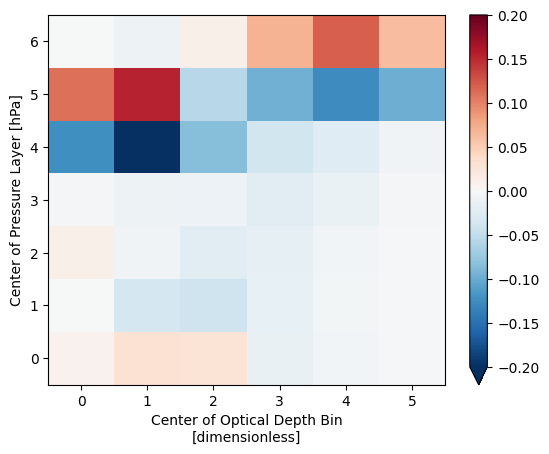

In [27]:
print("Tropical LW feedback = ", lwfeed_trops.sum(["press", "opt"]).data)
print("High cloud Tropical LW feedback = ", lwfeed_trops.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud Tropical LW feedback = ", lwfeed_trops.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
lwfeed_trops.plot(vmin=-0.2, vmax=0.2, cmap="RdBu_r")

In [116]:
print("Tropical LW feedback sd = ", np.sum( lw_feed_st))
print("High cloud Tropical LW feedback = ", np.sum( lw_feed_st[4:,:]))
print("Low-mid cloud Tropical LW feedback = ", np.sum( lw_feed_st[:4,:]))
#lwfeed_trop.plot(vmin=-0.2, vmax=0.2, cmap="RdBu_r")

Tropical LW feedback sd =  0.45531891384472994
High cloud Tropical LW feedback =  0.33091876560672445
Low-mid cloud Tropical LW feedback =  0.1244001482380055


In [117]:
#6
sw_feed =  np.zeros([7,6])
sw_feed_st = np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints = swR_trop_mean.sel(press=p, opt=od)
        sw_regress = stats.linregress(gmst_anom_raghu, bints)
        sw_feed[p, od] = sw_regress.slope
        sw_feed_st[p, od] = sw_regress.stderr

swfeed_trops = xa.DataArray(sw_feed, 
                    coords={"press": swR_trop_mean.press, "opt":swR_trop_mean.opt, 
                           },
                   )

0.7591123945845569
High cloud Tropical SW feedback =  0.4267327842237256
Low-mid cloud Tropical SW feedback =  0.3323796103608314


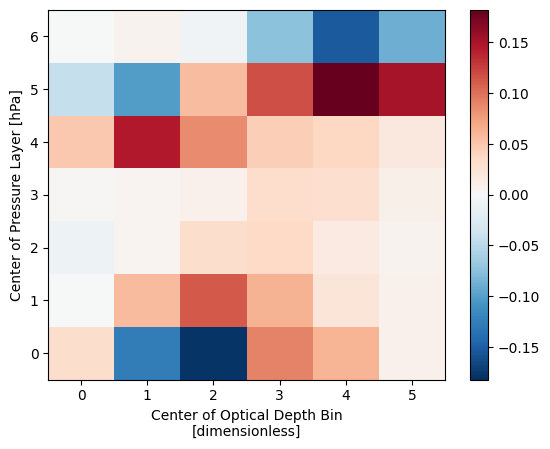

In [29]:
print(swfeed_trops.sum(["press", "opt"]).data)
print("High cloud Tropical SW feedback = ", swfeed_trops.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud Tropical SW feedback = ", swfeed_trops.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
(swfeed_trops).plot()

In [118]:
print("Tropical SW feedback sd = ", np.sum( sw_feed_st))
print("High cloud Tropical SW feedback = ", np.sum( sw_feed_st[4:,:]))
print("Low-mid cloud Tropical SW feedback = ", np.sum( sw_feed_st[:4,:]))

Tropical SW feedback sd =  0.7121341924627068
High cloud Tropical SW feedback =  0.3271086173848132
Low-mid cloud Tropical SW feedback =  0.3850255750778935


<xarray.DataArray ()>
array(0.23819301)
High cloud Tropical net feedback =  0.07665408461556661
Low-mid cloud Tropical net feedback =  0.16153892321190516


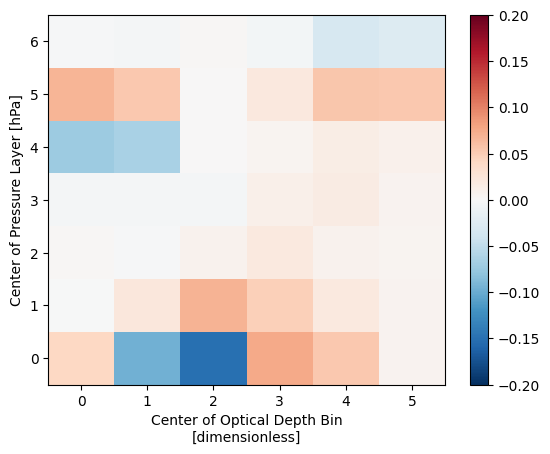

In [30]:
netfeed_trops = swfeed_trops + lwfeed_trops
print(netfeed_trops.sum(["press", "opt"]))
print("High cloud Tropical net feedback = ", netfeed_trops.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud Tropical net feedback = ", netfeed_trops.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
netfeed_trops.plot(vmin=-0.2, vmax=0.2, cmap="RdBu_r")

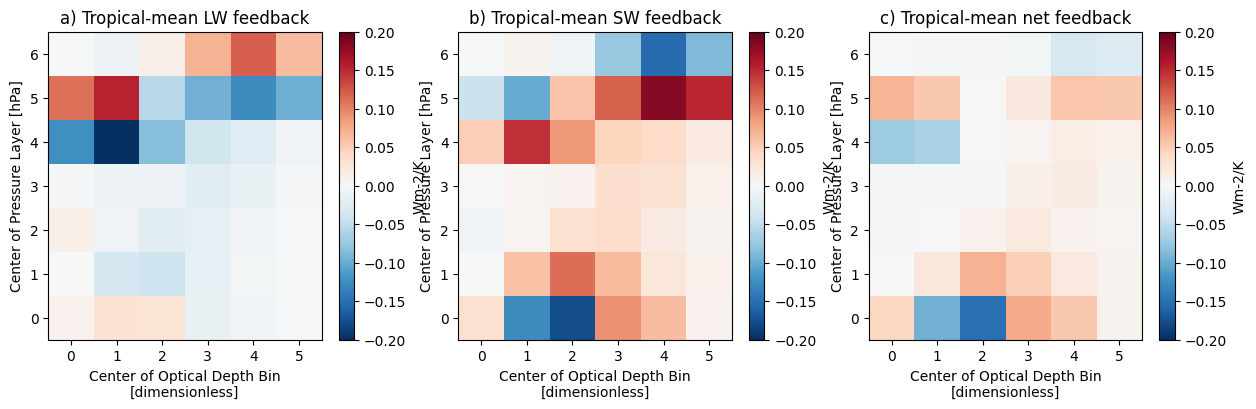

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

#fig.suptitle('Horizontally stacked subplots')
lwfeed_trops.plot(cmap="RdBu_r", vmin=-0.2, vmax=0.2, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax1)
ax1.set_title("a) Tropical-mean LW feedback")
swfeed_trops.plot(cmap="RdBu_r", vmin=-0.2, vmax=0.2, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax2)
ax2.set_title("b) Tropical-mean SW feedback")
netfeed_trops.plot(cmap="RdBu_r", vmin=-0.2, vmax=0.2, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax3)
ax3.set_title("c) Tropical-mean net feedback")
plt.savefig("feedbacks.png")

# ITCZ

In [56]:
itcz= slice(0,20)
ocean_only = slice(120,260)

In [57]:
RclrLW_itcz = alllw.sel(lat=itcz,lon=ocean_only, time=ragutime).toa_lw_clr_mon.mean("lon")
RovcLW_itcz = alllw.sel(lat=itcz,lon=ocean_only, time=ragutime).toa_lw_cldtyp_mon.mean("lon")
lwK_itcz = (RclrLW_itcz - RovcLW_itcz)/100

In [58]:
RclrSW_itcz = allsw.sel(lat=itcz,lon=ocean_only,time=ragutime).toa_sw_clr_mon.mean("lon")
RovcSW_itcz = allsw.sel(lat=itcz,lon=ocean_only,time=ragutime).toa_sw_cldtyp_mon.mean("lon")
swK_itcz = (RclrSW_itcz - RovcSW_itcz)/100

In [59]:
K_itcz = swK_itcz + lwK_itcz

Text(0.5, 1.0, 'c) ITCZ-mean net kernel')

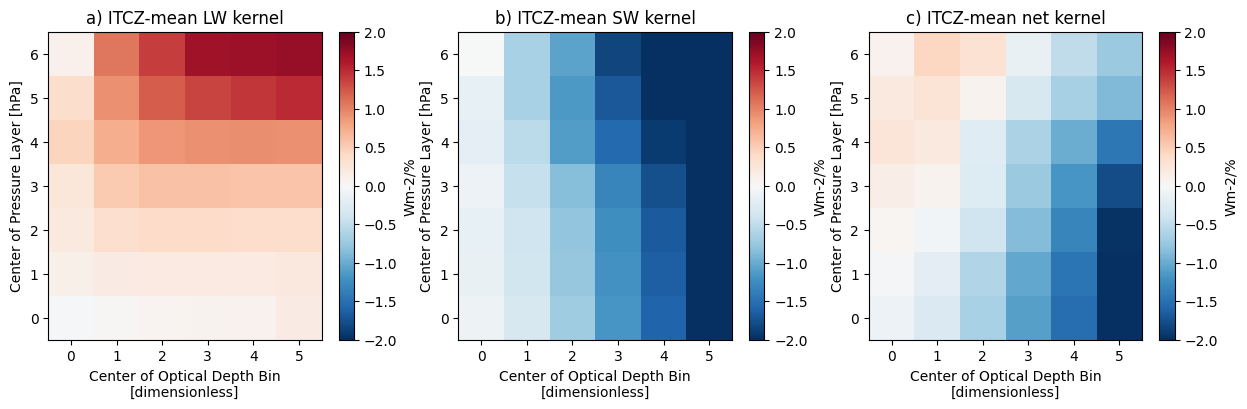

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

#fig.suptitle('Horizontally stacked subplots')
lwK_itcz.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax1)
ax1.set_title("a) ITCZ-mean LW kernel")
swK_itcz.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax2)
ax2.set_title("b) ITCZ-mean SW kernel")
K_itcz.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax3)
ax3.set_title("c) ITCZ-mean net kernel")
#plt.savefig("kernels.png")

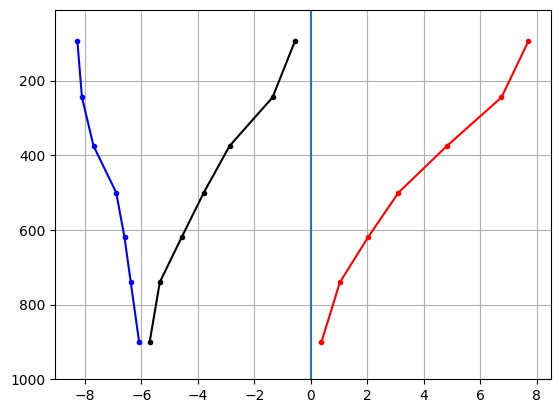

In [61]:
plt.plot(lwK_itcz.mean(["lat","time"]).sum("opt"),  midpoints[1:], ".-r")
plt.plot(swK_itcz.mean(["lat","time"]).sum("opt"),  midpoints[1:], ".-b")
plt.plot(K_itcz.mean(["lat","time"]).sum("opt"), midpoints[1:], ".-k")
plt.gca().invert_yaxis()
plt.ylim(1000,10)
plt.vlines(0, ymin=1000, ymax=10)
plt.grid()

IN conclusion, kernels dont change much with area or time

In [77]:
#2
area_itcz = alllw.cldarea_cldtyp_mon.sel(lat=itcz, lon=ocean_only,time=ragutime).mean("lon")
cc_itcz_anom = area_itcz.groupby('time.month')- area_itcz.groupby('time.month').mean('time')

In [78]:
#3
lwR_itcz = lwK_itcz*cc_itcz_anom
swR_itcz = swK_itcz*cc_itcz_anom

In [79]:
lwR_itcz_mean = lwR_itcz.mean("lat") 
swR_itcz_mean = swR_itcz.mean("lat")

In [92]:
lw_feed_itcz =  np.zeros([7,6])
lw_feed_itcz_st =  np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints_itcz = lwR_itcz_mean.sel(press=p, opt=od)
        lw_regress  = stats.linregress(gmst_anom_raghu, bints_itcz)
        lw_feed_itcz[p, od] = lw_regress.slope
        lw_feed_itcz_st[p, od] = lw_regress.stderr

lwfeed_itcz = xa.DataArray(lw_feed_itcz,  
                    coords={"press": lwR_itcz_mean.press, "opt":lwR_itcz_mean.opt, 
                           },
                   )

In [90]:
a = stats.linregress(gmst_anom_raghu, bints_itcz)
a.stderr

0.10125206297033008

1.1546197568658836
High cloud ITCZ SW feedback =  1.2884086179688683
Low-mid cloud ITCZ SW feedback =  -0.13378886110298477


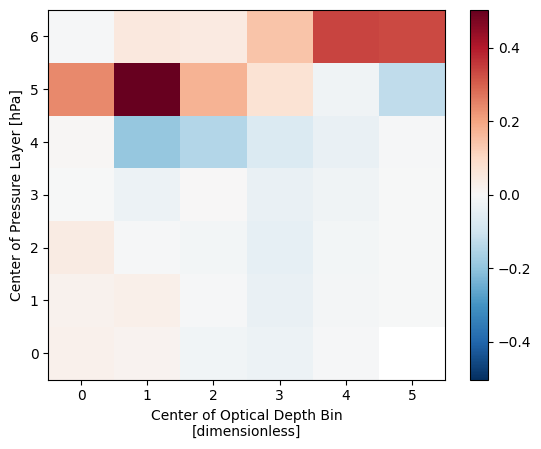

In [99]:
print(lwfeed_itcz.sum(["press", "opt"]).data)
print("High cloud ITCZ SW feedback = ", lwfeed_itcz.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud ITCZ SW feedback = ", lwfeed_itcz.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
(lwfeed_itcz).plot() #vmin=-0.2, vmax=0.2, cmap="RdBu_r"

In [95]:
sw_feed_itcz =  np.zeros([7,6])
for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints = swR_itcz_mean.sel(press=p, opt=od)
        sw_regress = stats.linregress(gmst_anom_raghu, bints).slope
        sw_feed_itcz[p, od] = sw_regress

swfeed_itcz = xa.DataArray(sw_feed_itcz, 
                    coords={"press": swR_itcz_mean.press, "opt":swR_itcz_mean.opt, 
                           },
                   )

0.49601346905805055
High cloud ITCZ SW feedback =  -1.2682239735173209
Low-mid cloud ITCZ SW feedback =  1.7642374425753717


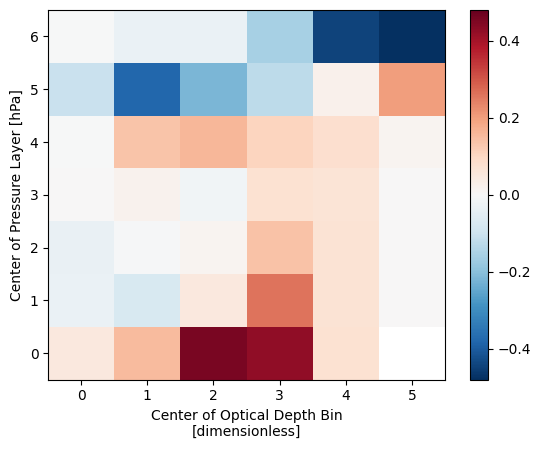

In [100]:
print(swfeed_itcz.sum(["press", "opt"]).data)
print("High cloud ITCZ SW feedback = ", swfeed_itcz.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud ITCZ SW feedback = ", swfeed_itcz.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
(swfeed_itcz).plot() #vmin=-0.2, vmax=0.2, cmap="RdBu_r"

<xarray.DataArray ()>
array(1.65063323)
High cloud Tropical net feedback =  0.02018464445154733
Low-mid cloud Tropical net feedback =  1.6304485814723868


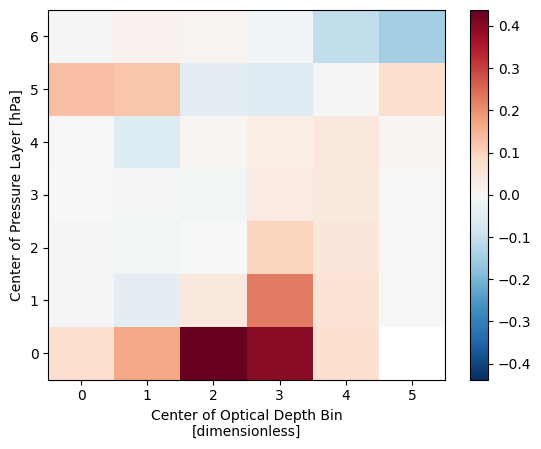

In [101]:
netfeed_itcz = swfeed_itcz + lwfeed_itcz
print(netfeed_itcz.sum(["press", "opt"]))
print("High cloud Tropical net feedback = ", netfeed_itcz.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud Tropical net feedback = ", netfeed_itcz.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
netfeed_itcz.plot() #vmin=-0.2, vmax=0.2, cmap="RdBu_r"

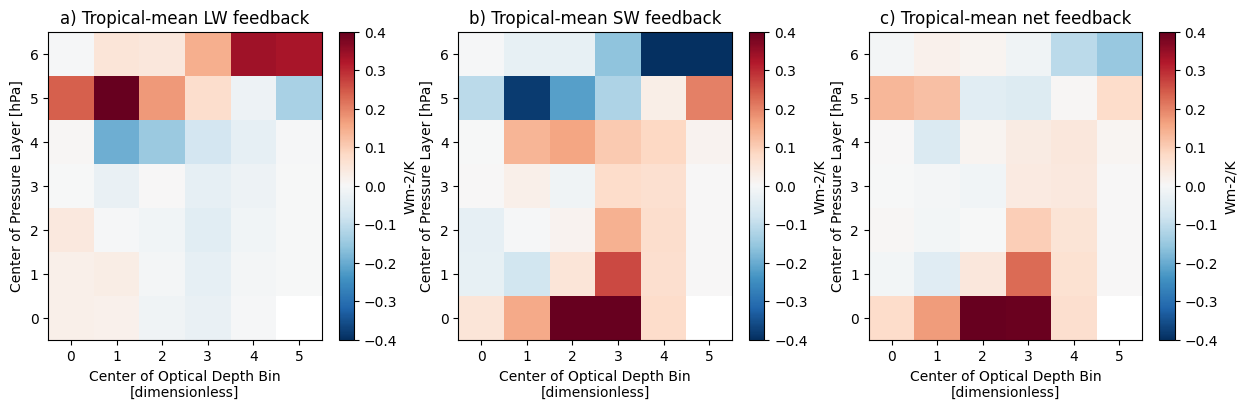

In [103]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

#fig.suptitle('Horizontally stacked subplots')
lwfeed_itcz.plot(cmap="RdBu_r", vmin=-0.4, vmax=0.4, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax1)
ax1.set_title("a) Tropical-mean LW feedback")
swfeed_itcz.plot(cmap="RdBu_r", vmin=-0.4, vmax=0.4, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax2)
ax2.set_title("b) Tropical-mean SW feedback")
netfeed_itcz.plot(cmap="RdBu_r", vmin=-0.4, vmax=0.4, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax3)
ax3.set_title("c) Tropical-mean net feedback")
plt.savefig("feedbacks_itcz")